# Finding external and internal contours in a binary image

Having contours extracted from a binary image gives you an alternative image representation and allows you to apply contour-specific image analysis methods. In this recipe, you will learn how to find contours in a binary image.

Contours are extracted using the OpenCV function `cv2.findContours`. It supports different contour extraction modes:

* `cv2.RETR_EXTERNAL`: For extracting only external contours 
* `cv2.RETR_CCOMP`: For extracting both internal and external contours, and organizing them into a two-level hierarchy 
* `cv2.RETR_TREE`: For extracting both internal and external contours, and organizing them into a tree graph 
* `cv2.RETR_LIST`: For extracting all contours without establishing any relationships

Also, you can specify whether contour compression is required (use `cv2.CHAIN_APPROX_SIMPLE` for collapsing vertical and horizontal parts of contours into their respective end points) or not (`cv2.CHAIN_APPROX_NONE`).

The function returns a tuple of three elements, modified image, list of contours, and list of contour hierarchy attributes. The hierarchy attributes describe the image contour topology, each list element is a four-element tuple containing zero-based indices of the next and previous contours at the same hierarchy level, then the first child and the first parent contours, respectively. If there's no contour, the corresponding index is `-1`.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images):
    #%pylab inline
    plt.figure(figsize=(15,6))
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis('off')
        plt.title(name)
        plt.imshow(img,cmap='gray' )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S03\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s03\env

d:\html_doc\program\opencv\packt\s03\env\lib\site-packages
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


------  Original-----------------    Shape(480, 640) image: uint8
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
Populating the interactive namespace from numpy and matplotlib


<Figure size 720x432 with 0 Axes>

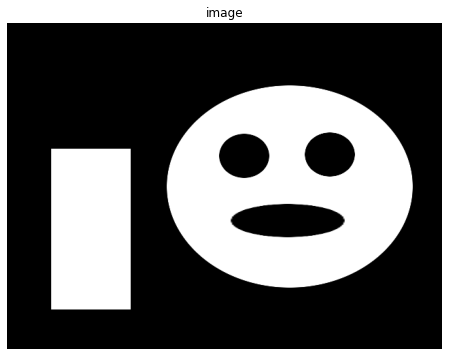

In [2]:
image = cv2.imread('data/BnW.png', 0)


##############################################
print_image('Original','image',image,0,2,0,15)
%pylab inline
plt.figure(figsize=(10,6))
plt_view_image(plt,[["image",image]   ])

In [3]:
#https://robotclass.ru/tutorials/opencv-python-find-contours/
#Функция OpenCV для поиска контуров findContours() 
#findContours( кадр, режим_группировки, метод_упаковки [, контуры[, иерархия[, сдвиг]]])
#  кадр - должным образом подготовленная для анализа картинка. Это должно быть 8-битное изображение. Поиск контуров 
#         использует для работы монохромное изображение, так что все пиксели картинки с ненулевым цветом будут 
#         интерпретироваться как 1, а все нулевые останутся нулями.
#  режим_группировки — один из четырех режимов группировки найденных контуров: 
#                      CV_RETR_LIST — выдаёт все контуры без группировки; 
#                      CV_RETR_EXTERNAL — выдаёт только крайние внешние контуры; 
#                      CV_RETR_CCOMP — группирует контуры в двухуровневую иерархию. 
#                                      На верхнем уровне — внешние контуры объекта. 
#                                      На втором уровне — контуры отверстий, если таковые имеются. 
#                                      Все остальные контуры попадают на верхний уровень; 
#                      CV_RETR_TREE — группирует контуры в многоуровневую иерархию.
#  метод_упаковки - один из трёх методов упаковки контуров: 
#                   CV_CHAIN_APPROX_NONE — упаковка отсутствует и все контуры хранятся в виде отрезков, состоящих из двух пикселей; 
#                   CV_CHAIN_APPROX_SIMPLE — склеивает все горизонтальные, вертикальные и диагональные контуры; 
#                   CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS — применяет к контурам метод упаковки (аппроксимации) Teh-Chin.
#  контуры — список всех найденных контуров, представленных в виде векторов; 
#  иерархия — информация о топологии контуров. 
#             Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
#  иерархия[i][0] — индекс следующего контура на текущем слое;
#             [i][1] — индекс предыдущего контура на текущем слое:
#                [i][2] — индекс первого контура на вложенном слое;
#                   [i][3] — индекс родительского контура.
#  сдвиг — величина смещения точек контура.

#По состоянию на 2019 год у нас есть три версии OpenCV (OpenCV2, OpenCV3 и OpenCV4).
#OpenCV4 и OpenCV2 имеют похожее поведение (возвращют два значения из cv2.findContours()). 
#Тогда как OpenCV3 возвращает три значения.
#imgs, contours, hierarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)



#############################################
for each in contours:
    print("contour.shape =",each.shape, type(each))
    for i in range (0,26):
        if i<each.shape[0]:
            print(each[i],end="")
    print()
print("hierarchy \n",hierarchy)

#контуры — список всех найденных контуров, представленных в виде векторов; 
#иерархия — информация о топологии контуров. 
#Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
#иерархия[i][0] — индекс следующего контура на текущем слое;
#           [i][1] — индекс предыдущего контура на текущем слое:
#              [i][2] — индекс первого контура на вложенном слое;
#                 [i][3] — индекс родительского контура.

contour.shape = (4, 1, 2) <class 'numpy.ndarray'>
[[ 65 186]][[ 65 421]][[181 421]][[181 186]]
contour.shape = (464, 1, 2) <class 'numpy.ndarray'>
[[396  93]][[395  94]][[387  94]][[386  95]][[380  95]][[379  96]][[374  96]][[373  97]][[370  97]][[369  98]][[365  98]][[364  99]][[361  99]][[360 100]][[358 100]][[357 101]][[354 101]][[353 102]][[351 102]][[350 103]][[348 103]][[347 104]][[345 104]][[344 105]][[342 105]][[341 106]]
contour.shape = (132, 1, 2) <class 'numpy.ndarray'>
[[392 268]][[393 267]][[432 267]][[433 268]][[441 268]][[442 269]][[452 269]][[453 270]][[456 270]][[457 271]][[459 271]][[460 272]][[466 272]][[467 273]][[468 273]][[469 274]][[473 274]][[474 275]][[476 275]][[478 277]][[479 277]][[480 278]][[484 278]][[485 279]][[485 280]][[486 280]]
contour.shape = (96, 1, 2) <class 'numpy.ndarray'>
[[339 165]][[340 164]][[357 164]][[358 165]][[361 165]][[362 166]][[363 166]][[364 167]][[366 167]][[367 168]][[368 168]][[370 170]][[371 170]][[375 174]][[376 174]][[377 175]]

In [4]:
#https://robotclass.ru/tutorials/opencv-python-find-contours/
# Функция для отображения контуров  
#drawContours( кадр, контуры, индекс, цвет[, толщина[, тип_линии[, иерархия[, макс_слой[, сдвиг]]]]])
#  контуры — те самые контуры, найденные функцией findContours() ;
#  индекс — индекс контура, который следует отобразить. -1 — если нужно отобразить все контуры;
#  цвет — цвет контура;
#  толщина — толщина линии контура;
#  тип_линии — тип соединения точек вектора;
#              LINE_8 (or omitted) — 8-connected line.
#              LINE_4 — 4-connected line.
#              LINE_AA — antialiased line.
#  иерархия — информация об иерархии контуров;  иерархия — информация о топологии контуров. 
#             Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i] ;
#  макс_слой — индекс слоя, который следует отображать. 
#              Если параметр равен 0, то будет отображен только выбранный контур. 
#              Если параметр равен 1, то отобразится выбранный контур и все его дочерние контуры. 
#              Если параметр равен 2, то отобразится выбранный контур, все его дочерние и дочерние дочерних!
#  сдвиг — величина смещения точек контура.

image_external = np.zeros(image.shape, image.dtype)



#############################################
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(image_external, contours, i, 255, -1)
        print(hierarchy[0][i])
#контуры — список всех найденных контуров, представленных в виде векторов; 
#иерархия — информация о топологии контуров. 
#Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
#иерархия[i][0] — индекс следующего контура на текущем слое;
#           [i][1] — индекс предыдущего контура на текущем слое:
#              [i][2] — индекс первого контура на вложенном слое;
#                 [i][3] — индекс родительского контура.

[ 1 -1 -1 -1]
[-1  0  2 -1]


In [5]:
image_internal = np.zeros(image.shape, image.dtype)



#############################################
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(image_internal, contours, i, 255, -1)
        print(hierarchy[0][i])

[ 3 -1 -1  1]
[ 4  2 -1  1]
[-1  3 -1  1]


<Figure size 720x216 with 0 Axes>

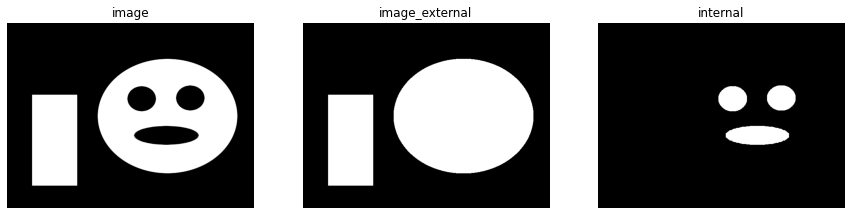

In [6]:
plt.figure(figsize=(10,3))
plt_view_image(plt,[["image",image], ["image_external",image_external],["internal",image_internal] ])